In [6]:
import os
import cv2
import time
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from google.colab import drive
from keras.utils import to_categorical
from google.colab.patches import cv2_imshow

In [ ]:

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
def computeMetrics(y_test, y_pred, training_time):
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    #auc = roc_auc_score(y_test, y_pred, average='macro')        # Calcular AUC , "AUC":auc}
    
    #true_labels_binary = label_binarize(y_test, classes=[0,1,2,3])
    #auc_ = roc_auc_score(true_labels_binary, y_pred.reshape(-1, 1), average='macro')
    
    #n_classes = 4
    #print(y_test)
    #print(y_pred.shape)
    #y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    #y_pred_bin = np.zeros((len(y_test), n_classes))
    #y_pred_bin[np.arange(len(y_test)), y_pred] = 1    
    #print(y_pred_bin)
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "Tiempo de entrenamiento":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

    # Calcular la curva ROC

    #fpr = dict()
    #tpr = dict()
    #roc_auc = dict()#

    #for i in range(n_classes):
    #    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    #    roc_auc[i] = auc(fpr[i], tpr[i])
    
    #plt.figure()

    #for i in range(n_classes):
    #    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

    #plt.plot([0, 1], [0, 1], 'k--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #plt.title('Receiver Operating Characteristic')
    #plt.legend(loc='lower right')
    #plt.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia
(1345, 299, 299)


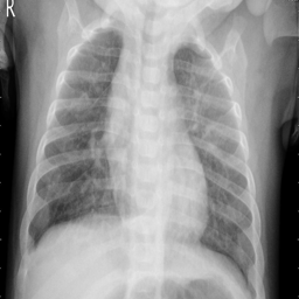

In [8]:
# Ruta a la carpeta del conjunto de datos en Google Drive
#data_folders =  ["/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID", "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Lung_Opacity",
#                 "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Normal", "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia"]

data_folders =  ["/content/drive/MyDrive/COVID-19_Radiography_Dataset/Viral Pneumonia"]

# Cargar y procesar el conjunto de datos
images = []
labels = []

class_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

for i, data_folder in enumerate(data_folders):
    image_files = os.listdir(data_folder)
    print(data_folder)
    for filename in image_files:
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (299, 299))
        # Especificar el tamaño del recorte de bordes
        #recorte_bordes = 50

        # Calcular las nuevas dimensiones
        #nuevo_alto = 299 - 2 * recorte_bordes
        #nuevo_ancho = 299 - 2 * recorte_bordes

        # Recortar la imagen eliminando los bordes
        #image = image[recorte_bordes:299-recorte_bordes, recorte_bordes:299-recorte_bordes]

        images.append(image)
        label = i  # Asignar la etiqueta de clase según el índice
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

print(images.shape)
cv2_imshow(images[2])


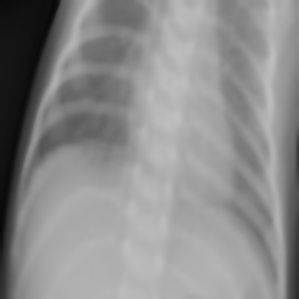

In [9]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Aplicar el filtro bilateral a las imágenes offline y guardarlas
filtered_train_images = np.empty_like(train_images)
filtered_test_images = np.empty_like(test_images)

for i in range(len(train_images)):
    filtered_image = cv2.bilateralFilter(train_images[i], 9, 75, 75)
    filtered_train_images[i] = filtered_image

for i in range(len(test_images)):
    filtered_image = cv2.bilateralFilter(test_images[i], 9, 75, 75)
    filtered_test_images[i] = filtered_image

cv2_imshow(filtered_train_images[2])

In [14]:
# Definir la arquitectura de la CNN
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Compilar y entrenar la CNN con imágenes en bruto
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
model.fit(train_images, train_labels, epochs=1, batch_size=32, validation_data=(test_images, test_labels))
end_time = time.time()
time_taken = end_time - start_time
# Evaluar la CNN con imágenes en bruto
#-----------------------------------------------------------------------------
# Obtener las predicciones del modelo en las imágenes de prueba
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

#-----------------------------------------------------------------------------

computeMetrics(test_labels,predictions,time_taken)


9/9 [==============================] - 6s 606ms/step


,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento
0,1.0,1.0,1.0,1.0,116.681565


1/1 [==============================] - 3s 3s/step
[[[[1.6085992  0.320767   0.         ... 1.3370451  1.1927361
    0.01703758]
   [2.0024588  0.05895612 0.4688827  ... 1.841355   1.0213466
    0.9007174 ]
   [0.         1.1066909  0.         ... 1.4300718  0.6798425
    1.7671154 ]
   ...
   [0.         0.18607095 0.56327176 ... 0.2297382  0.87358415
    0.5476161 ]
   [0.14582312 0.         0.15034088 ... 0.         0.3580228
    0.5928637 ]
   [0.1654292  0.         0.         ... 0.         0.
    0.8605884 ]]

  [[0.6604353  0.13038483 0.24725634 ... 2.028822   1.3613868
    0.12499844]
   [1.2795426  0.08361152 0.         ... 2.42631    1.2966957
    0.9672611 ]
   [1.1194024  0.21536484 0.         ... 2.1700497  0.98348296
    1.8291259 ]
   ...
   [1.3531353  0.         0.         ... 0.9698142  1.1467593
    0.48733425]
   [0.76780725 0.         0.         ... 0.6037029  0.8626837
    0.44096154]
   [0.         0.         0.         ... 0.38004744 0.4324522
    0.5317509 ]]

 

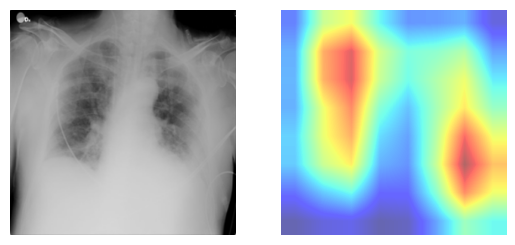

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Cargar el modelo InceptionV3 pre-entrenado
model = InceptionV3(weights='imagenet')

# Cargar una imagen de ejemplo
img_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Obtener la capa de interés
layer_name = 'mixed10'
last_conv_layer = model.get_layer(layer_name)

# Crear un nuevo modelo que incluya solo las capas hasta la capa de interés
new_model = tf.keras.models.Model(inputs=model.input, outputs=last_conv_layer.output)

# Obtener los mapas de activación de la capa de interés
activations = new_model.predict(x)
print(activations)
# Calcular los valores de importancia de los mapas de activación
importance_values = np.mean(activations, axis=(0, 1))


# Ajustar el tamaño del peso para que coincida con el tamaño del mapa de activación
weights = np.expand_dims(np.expand_dims(importance_values, axis=0), axis=0)

# Generar el mapa de calor ponderado
heatmap = tf.reduce_sum(tf.multiply(weights, activations), axis=-1)[0]

# Normalizar el mapa de calor
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Ajustar el tamaño del mapa de calor para que coincida con el tamaño de la imagen
heatmap = np.expand_dims(heatmap, axis=-1)
heatmap = tf.image.resize(heatmap, (img.size[1], img.size[0]))
heatmap = tf.squeeze(heatmap)
heatmap = heatmap.numpy()

# Visualizar la imagen original
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

# Visualizar el mapa de calor
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet', alpha=0.6)
plt.axis('off')

plt.show()